# Federated learning for ECG Arrhythmia detection

In [ ]:
import logging
from collections import OrderedDict
from pathlib import Path
from typing import Dict, Optional, Tuple

import lightning as L
import matplotlib.pyplot as plt
import torch
from datasets.utils.logging import disable_progress_bar
from dotenv import load_dotenv
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Context, NDArrays, Scalar, log, ndarrays_to_parameters
from flwr.server import ServerApp, ServerAppComponents, ServerConfig
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets.visualization import plot_label_distributions
from lightning.pytorch.callbacks import TQDMProgressBar
from torch.utils.data import DataLoader

import wandb
from dataset_utils import Cinc2017DataModuleFL
from model import DenseNet1dModule

/home/g113056077/.pyenv/versions/ecg-fl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-01 21:37:13,899	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# disable unnecessary logging on the server side
logging.getLogger("lightning.pytorch.utilities.rank_zero").disabled = True
logging.getLogger("lightning.pytorch.accelerators.cuda").disabled = True
disable_progress_bar()

## Config

In [ ]:
# .env
load_dotenv()

# server side
NUM_CLIENTS = 5
NUM_ROUNDS = 10

# client side
MAX_EPOCHS = 10
BATCH_SIZE = 64
INIT_LR = 2e-3

# dataset
NON_IID = True
DIRICHLET_ALPHA = 0.5

## Logging to Wandb

In [4]:
wandb.init(
    project="ecg-federated",
    name="ecg-federated",
    dir="wandb_logs",
    config={
        "NUM_CLIENTS": NUM_CLIENTS,
        "NUM_ROUNDS": NUM_ROUNDS,
        "MAX_EPOCHS": MAX_EPOCHS,
        "BATCH_SIZE": BATCH_SIZE,
        "INIT_LR": INIT_LR,
        "NON_IID": NON_IID,
        "DIRICHLET_ALPHA": DIRICHLET_ALPHA,
    },
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: devilhyt. Use `wandb login --relogin` to force relogin
/home/g113056077/.pyenv/versions/ecg-fl/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:84: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import HTML, display  # type: ignore


## Prepare the Dataset and Dataloader

In [5]:
dm = Cinc2017DataModuleFL(batch_size=BATCH_SIZE, num_partitions=NUM_CLIENTS)
dm.setup("client", NON_IID, DIRICHLET_ALPHA)

# dataloaders for server side evaluation
dm.setup("train_eval")
train_loader = dm.train_eval_dataloader()
dm.setup("validate")
valid_loader = dm.val_dataloader()

## Observe the data distribution of each client.

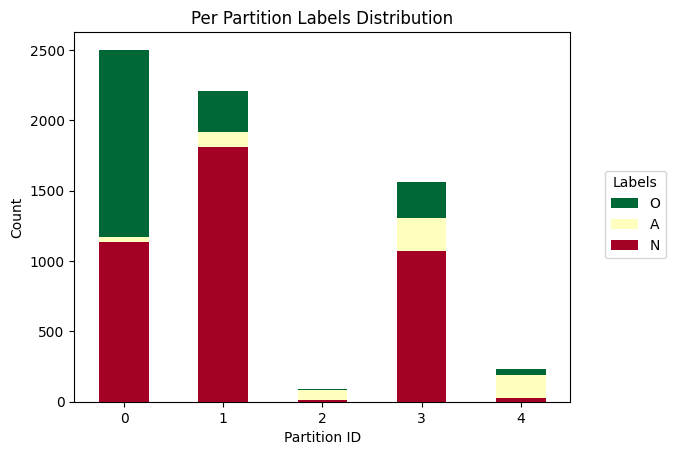

In [6]:
fig, ax, df = plot_label_distributions(
    dm.client_set_partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution",
)
plt.show()

wandb.log({"label_distribution": fig}, step=0)

## Flower Client App

In [7]:
def get_parameters(model: DenseNet1dModule) -> list:
    return [val.cpu().numpy() for _, val in model.state_dict().items()]


def set_parameters(model: DenseNet1dModule, parameters):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)

In [8]:
class FlowerClient(NumPyClient):
    def __init__(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        max_epochs: int,
    ):
        # disable unnecessary logging for each client
        logging.getLogger("lightning.pytorch.utilities.rank_zero").disabled = True
        logging.getLogger("lightning.pytorch.accelerators.cuda").disabled = True

        self.model = None
        self.max_epochs = max_epochs
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        # create a model
        self.model = DenseNet1dModule(
            num_classes=dm.num_classes,
            show_valid_cm=False,
            memory_efficient=False,
            lr=config["lr"],
        )

        # get the global model from the server
        set_parameters(self.model, parameters)

        # define trainer
        trainer = L.Trainer(
            max_epochs=self.max_epochs,
            enable_progress_bar=False,
            enable_model_summary=False,
            enable_checkpointing=False,
            logger=False,
        )

        # train the model
        trainer.fit(self.model, self.train_dataloader, self.valid_dataloader)

        return get_parameters(self.model), len(self.train_dataloader.dataset), {}


def client_fn(context: Context) -> Client:
    partition_id = context.node_config["partition-id"]
    train_dataloader, valid_dataloader = dm.client_dataloaders(partition_id)

    return FlowerClient(train_dataloader, valid_dataloader, MAX_EPOCHS).to_client()

## Flower Server App

In [9]:
best_valid_loss = float("inf")
checkpoint_path = Path(f"wandb_logs/ecg-federated/{wandb.run.id}")


def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    """Server-side parameter evaluation"""
    model = DenseNet1dModule(num_classes=dm.num_classes, memory_efficient=False)
    set_parameters(model, parameters)

    trainer = L.Trainer(
        enable_progress_bar=False, enable_model_summary=False, logger=False
    )

    # Evaluate on the train set
    # We place train evaluation on the server side for convenience.
    # In a real-world scenario, this should be done on the client side.
    train_result = trainer.validate(model, train_loader, verbose=False)[0]
    for key in ["loss", "acc", "f1"]:
        train_result[f"train_{key}"] = train_result.pop(f"valid_{key}")
    wandb.log(train_result, step=server_round)

    # Evaluate on the valid set
    valid_result = trainer.validate(model, valid_loader, verbose=False)[0]
    wandb.log(valid_result, step=server_round)

    # Save the checkpoint
    global best_valid_loss
    valid_loss = valid_result["valid_loss"]
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        trainer.save_checkpoint(checkpoint_path / "best.ckpt", model)
        log(logging.INFO, "Best model updated and saved.")
    trainer.save_checkpoint(checkpoint_path / "latest.ckpt", model)

    return valid_loss, {**train_result, **valid_result}


def fit_config(server_round: int):
    # Learning rate schedule
    # Reduce learning rate by 0.5 every 1/3 of the total rounds
    step = max(1, NUM_ROUNDS // 3)
    lr = INIT_LR * 0.5 ** ((server_round - 1) // step)
    config = {"lr": lr}

    log(logging.INFO, f"Learning rate: {lr}")
    wandb.log(config, step=server_round)
    return config


def server_fn(context: Context) -> ServerAppComponents:
    # Convert model parameters to flwr.common.Parameters
    init_model = DenseNet1dModule(num_classes=dm.num_classes, memory_efficient=False)
    ndarrays = get_parameters(init_model)
    initial_parameters = ndarrays_to_parameters(ndarrays)

    # Define strategy
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0,
        min_fit_clients=NUM_CLIENTS,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=initial_parameters,
        evaluate_fn=evaluate,
        on_fit_config_fn=fit_config,
    )

    # Construct ServerConfig
    config = ServerConfig(num_rounds=NUM_ROUNDS)

    return ServerAppComponents(strategy=strategy, config=config)

## Run Simulation

In [10]:
backend_config = {
    "client_resources": {"num_cpus": 1, "num_gpus": 1 / (NUM_CLIENTS + 1)}
}

run_simulation(
    server_app=ServerApp(server_fn=server_fn),
    client_app=ClientApp(client_fn=client_fn),
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Best model updated and saved.
INFO :      initial parameters (loss, other metrics): 1.137862205505371, {'train_loss': 1.137991189956665, 'train_acc': 0.3333333432674408, 'train_f1': 0.1510392278432846, 'valid_loss': 1.137862205505371, 'valid_acc': 0.3333333432674408, 'valid_f1': 0.15071919560432434}
INFO :      
INFO :      [ROUND 1]
INFO :      Learning rate: 0.002
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Best model updated and saved.
INFO :      fit progress: (1, 0.8462121486663818, {'train_loss': 0.8273081183433533, 'train_acc': 0.3862413763999939, 'train_f1': 0.3539204001426697, 'valid_loss': 0.8462121486663818, 'valid_acc': 0.365086615085601

## Evaluation and Visualization on the Test set.

In [11]:
progress_bar_callback = TQDMProgressBar(leave=True)

trainer = L.Trainer(
    callbacks=[progress_bar_callback],
    logger=False,
)

In [12]:
model = DenseNet1dModule.load_from_checkpoint(checkpoint_path / "best.ckpt")
result = trainer.test(model, datamodule=dm)
wandb.log(result[0], step=NUM_ROUNDS+1)

Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 40.00it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7824188470840454     │
│          test_f1          │    0.7971699237823486     │
│         test_loss         │     0.558036208152771     │
└───────────────────────────┴───────────────────────────┘

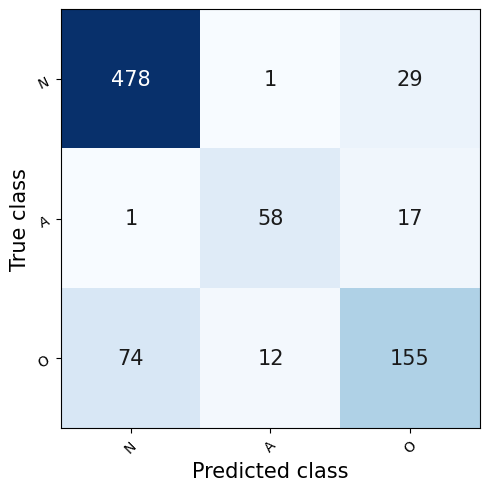

In [14]:
fig, ax = model.test_cm.plot(
    model.test_cm_log, cmap="Blues", labels=dm.test_set.classes
)
plt.show()
wandb.log({"test_cm": fig}, step=NUM_ROUNDS + 1)

## Save the Latest and Best Models

In [13]:
for model_type in ["best", "latest"]:
    model_artifact = wandb.Artifact(name=f"model-{wandb.run.id}", type="model")
    model_artifact.add_file(checkpoint_path / f"{model_type}.ckpt")
    wandb.log_artifact(model_artifact, aliases=[model_type])

In [15]:
wandb.finish()

/home/g113056077/.pyenv/versions/ecg-fl/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:84: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display



lr,███▄▄▄▂▂▂▁
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▂▆▇▇██████
train_f1,▁▃▇▇███████
train_loss,█▅▃▂▂▂▂▁▁▁▁
valid_acc,▁▁▆▇▇█▇████
valid_f1,▁▃▇▇███████
valid_loss,█▅▂▂▁▁▁▁▁▁▁
lr,0.00025
